# Выбор локации для скважины

Цель проекта - ыбор наиболее выгодного региона для добычи нефти.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль, провести анализ возможной прибыли и рисков.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

In [2]:
df1 = pd.read_csv('D:\\Documents\\ds\\oil\\geo_data_0.csv')
df2 = pd.read_csv('D:\\Documents\\ds\\oil\\geo_data_1.csv')
df3 = pd.read_csv('D:\\Documents\\ds\\oil\\geo_data_2.csv')

# df1 = pd.read_csv('/datasets/geo_data_0.csv')
# df2 = pd.read_csv('/datasets/geo_data_1.csv')
# df3 = pd.read_csv('/datasets/geo_data_2.csv')

def df_inf(inf, x):
    print(inf, '\n')
    x.info()
    print('Количество дубликатов:', x.duplicated().sum())
    display(x.head())

df_inf('Датафрейм 1-го региона', df1)
df_inf('Датафрейм 2-го региона', df2)
df_inf('Датафрейм 3-го региона', df3)

Датафрейм 1-го региона 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Количество дубликатов: 0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Датафрейм 2-го региона 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Количество дубликатов: 0


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Датафрейм 3-го региона 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Количество дубликатов: 0


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


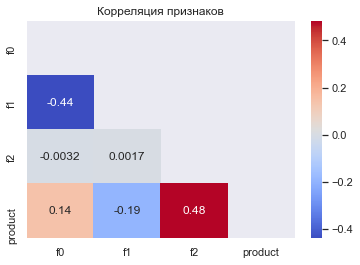

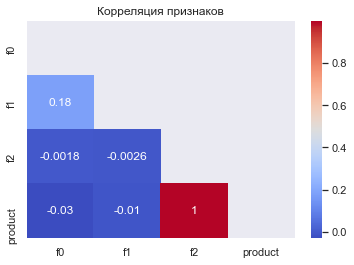

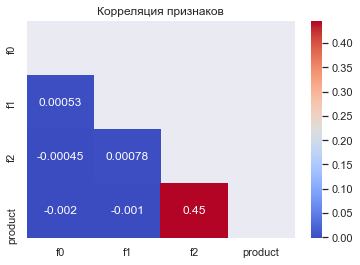

In [3]:
# Проверка на корреляцию признаков
for i in (df1, df2, df3):
    i.drop(['id'], inplace=True, axis=1)
    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1)
    matrix = np.triu(i.corr())
    sns.heatmap(i.corr(), annot=True, cmap= 'coolwarm', mask = matrix)
    plt.title('Корреляция признаков')
    plt.show()
    print()

### Вывод
Предоставленные 3 датасета, содержащие по 100000 строк и 5 столбцов.  
Пропусков и дубликатов в предоставленных датасетах нет.  
Столбец 'id' не влияет на целевой признак, поэтому был удален.  
В датафрейме 2-го региона сильная корреляция признака 'f2' и целевого признака 'product'.

## Обучение и проверка модели

In [4]:
def calc(df):
    # Разбивка данных на обучающую и валидационную выборки
    features = df.drop('product', axis=1)
    target = df['product']
    target = df['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    
    # Обучение модели и выполнение предсказания на валидационной выборке
    parametrs = [{'fit_intercept':[True, False], 'copy_X': [True, False], 'positive': [True, False]}]
    model = GridSearchCV(LinearRegression(), parametrs, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    model.fit(features_train, target_train)
    pred = model.predict(features_valid)
    
    # Сохраниние предсказаний и правильных ответов в валидационной выборке
    s = pd.Series(pred)
    valid_pred = pd.DataFrame({'valid':target_valid.values, 'pred':s.values})
    valid_pred.rename(columns={0: 'pred'}, inplace=True)
    
    # Сохранение в переменных среднего запаса предсказанного сырья и RMSE 
    stock = valid_pred['pred'].mean()
    rmse = sqrt(mean_squared_error(target_valid, pred))
    
    return valid_pred, stock, rmse

In [5]:
valid_pred1, stock1, rmse1 = calc(df1)
valid_pred2, stock2, rmse2 = calc(df2)
valid_pred3, stock3, rmse3 = calc(df3)

In [6]:
print(f"  1-ый регион: \n Средний запас предсказанного сырья {stock1: .0f} \n RMSE модели {rmse1: .1f} \n")
print(f"  2-ый регион: \n Средний запас предсказанного сырья {stock2: .0f} \n RMSE модели {rmse2: .1f} \n")
print(f"  3-ый регион: \n Средний запас предсказанного сырья {stock3: .0f} \n RMSE модели {rmse3: .1f} \n")

  1-ый регион: 
 Средний запас предсказанного сырья  93 
 RMSE модели  37.6 

  2-ый регион: 
 Средний запас предсказанного сырья  69 
 RMSE модели  0.9 

  3-ый регион: 
 Средний запас предсказанного сырья  95 
 RMSE модели  40.0 



### Вывод
Самый высокий запас предсказанного сырья в 1-ом и 3-м регионе, самый низкий во 2-ом.  
RMSE модели 2-го региона имеет очень низкий показатель, что объясняется высокой корреляцией признака 'f2' и целевого признака 'product'.

## Подготовка к расчёту прибыли

In [7]:
VOLUME = 10000000000
REVENUE = 450000
TEST_POINT = 500
BEST_POINT = 200
ALPHA = 0.025

In [8]:
volum_oil = VOLUME / REVENUE / BEST_POINT
print(f'Достаточный объём сырья для безубыточной разработки новой скважины - {volum_oil: .0f} тыс. баррелей')

Достаточный объём сырья для безубыточной разработки новой скважины -  111 тыс. баррелей


### Вывод
Достаточный объём сырья для безубыточной разработки новой скважины выше чем средний запас предсказанного сырья по каждому региону.   
Для получения прибыли при добыче необходимо выбирать скважины с наибольшим запасом сырья.

## Расчёт прибыли и рисков 

In [9]:
def profit(valid_pred):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        # Применение техники Bootstrap для вычисления распределения прибыли 
        subsample = valid_pred.sample(n=500, replace=True, random_state=state)
        sub = subsample.sort_values(by='pred', ascending=False).head(200)
        profit = sub['valid'].sum() * REVENUE - VOLUME
        values.append(profit)
        
    values = pd.Series(values)
    
    # Расчет 95%-ого доверительного интервала 
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    
    # Расчет средней прибыли 200 лучших скважин
    profit_mean = values.mean()
    
    # Расчет риска убытков
    risk_loss = (values < 0).mean()
    
    return profit_mean, risk_loss, lower, upper

In [10]:
profit_mean1, risk_loss1, lower1, upper1 = profit(valid_pred1)
profit_mean2, risk_loss2, lower2, upper2 = profit(valid_pred2)
profit_mean3, risk_loss3, lower3, upper3 = profit(valid_pred3)

In [11]:
print(f'   1-ый регион: \n'
      f' Cредняя прибыль - {profit_mean1: .0f} \n'
      f' 95%-й доверительный интервал ({lower1: .0f} {upper1: .0f}) \n'
      f' риск убытков {risk_loss1: .3f} \n')

print(f'   2-ой регион: \n'
      f' Cредняя прибыль - {profit_mean2: .0f} \n'
      f' 95%-й доверительный интервал ({lower2: .0f} {upper2: .0f}) \n'
      f' риск убытков {risk_loss2: .3f} \n') 

print(f'   3-ий регион: \n'
      f' Cредняя прибыль - {profit_mean3: .0f} \n'
      f' 95%-й доверительный интервал ({lower3: .0f} {upper3: .0f}) \n'
      f' риск убытков {risk_loss3: .3f}') 

   1-ый регион: 
 Cредняя прибыль -  396164985 
 95%-й доверительный интервал (-111215546  909766942) 
 риск убытков  0.069 

   2-ой регион: 
 Cредняя прибыль -  456045106 
 95%-й доверительный интервал ( 33820509  852289454) 
 риск убытков  0.015 

   3-ий регион: 
 Cредняя прибыль -  404460705 
 95%-й доверительный интервал (-165693883  946444849) 
 риск убытков  0.077


### Вывод
Средняя прибыль при добычи самая высокая во 2-ом регионе.  
Диапазон 95%-го доверительного интервала во 2-ом регионе выше, чем в других регионах и не включает убытки.  
Риск убытков составляет 1,5% что ниже допустимого (2,5%) и ниже, чем в других регионах.  
По результатам проведенного исследования для добычи сырья необходимо выбрать 2-ой регион. 